# **Car Price Model - Neural Network**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Import Data

In [2]:
# ================= import data =================
dataFile = 'audi.csv'
data = pd.read_csv(dataFile, sep=',')
data

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0
...,...,...,...,...,...,...,...,...,...
10663,A3,2020,16999,Manual,4018,Petrol,145,49.6,1.0
10664,A3,2020,16999,Manual,1978,Petrol,150,49.6,1.0
10665,A3,2020,17199,Manual,609,Petrol,150,49.6,1.0
10666,Q3,2017,19499,Automatic,8646,Petrol,150,47.9,1.4


Exploratory Data Analysis

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64
price         1.000000
year          0.592581
engineSize    0.591262
tax           0.356157
mileage      -0.535357
mpg          -0.600334
Name: price, dtype: float64


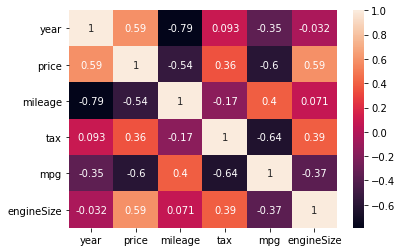

In [3]:
# ============= EDA ======================
print(data.isnull().sum())

# correlation matrix
corr_matrix = data.corr()
print(corr_matrix['price'].sort_values(ascending=False))

# heatmap
sns.heatmap(corr_matrix, annot=True)

One-Hot Encoding

In [4]:
# one-hot encoding for categorical attributes
data_onehot = pd.get_dummies(data, columns=['model', 'transmission', 'fuelType'])
data_onehot

,year,price,mileage,tax,mpg,engineSize,model_ A1,model_ A2,model_ A3,model_ A4,model_ A5,model_ A6,model_ A7,model_ A8,model_ Q2,model_ Q3,model_ Q5,model_ Q7,model_ Q8,model_ R8,model_ RS3,model_ RS4,model_ RS5,model_ RS6,model_ RS7,model_ S3,model_ S4,model_ S5,model_ S8,model_ SQ5,model_ SQ7,model_ TT,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol
0,2017,12500,15735,150,55.4,1.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,2016,16500,36203,20,64.2,2.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,2016,11000,29946,30,55.4,1.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,2017,16800,25952,145,67.3,2.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,2019,17300,1998,145,49.6,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10663,2020,16999,4018,145,49.6,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
10664,2020,16999,1978,150,49.6,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
10665,2020,17199,609,150,49.6,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
10666,2017,19499,8646,150,47.9,1.4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


Correlation Matrix After One-Hot Encoding

In [5]:
corr_matrix_onehot = data_onehot.corr()
corr_matrix_onehot['price'].sort_values(ascending=False)

price                     1.000000
year                      0.592581
engineSize                0.591262
model_ Q7                 0.367410
tax                       0.356157
model_ R8                 0.327367
transmission_Automatic    0.264294
transmission_Semi-Auto    0.259356
model_ Q8                 0.256350
model_ Q5                 0.192868
model_ RS6                0.170989
model_ RS5                0.126436
model_ RS4                0.125603
model_ A8                 0.109107
model_ SQ7                0.061673
model_ A7                 0.054804
model_ RS3                0.053039
fuelType_Hybrid           0.031946
fuelType_Diesel           0.030452
model_ SQ5                0.028185
model_ S4                 0.023924
model_ S8                 0.018039
model_ A5                 0.017438
model_ RS7                0.008756
model_ Q3                 0.003427
model_ A6                -0.004719
model_ S3                -0.008834
model_ Q2                -0.009366
model_ S5           

Data Preprocessing

In [6]:
# separate features and target variable
X = data_onehot.drop(['price'], axis=1)
Y = data_onehot[['price']]

# split training:validation:test as 60%:20%:20%
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_full, Y_train_full, test_size=0.25, random_state=42)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

scalerX = StandardScaler()
X_train_scaled = scalerX.fit_transform(X_train)
X_valid_scaled = scalerX.transform(X_valid)
X_test_scaled = scalerX.transform(X_test)

scalerY = StandardScaler()
Y_train_scaled = scalerY.fit_transform(Y_train)
Y_valid_scaled = scalerY.transform(Y_valid)
Y_test_scaled = scalerY.transform(Y_test)


(6400, 37)
(2134, 37)
(2134, 37)


Modeling

In [7]:
# ========================= Modeling ==============================

input_shape = X_train.shape[1:]


def build_model(n_hidden=1, n_neurons=38, learning_rate=0.01, init='glorot_uniform'):
    model = keras.models.Sequential()

    # input layer
    model.add(layers.Dense(38, activation='elu', kernel_initializer=init, input_shape=input_shape))

    # hidden layers
    for layer in range(n_hidden):
        model.add(layers.Dense(n_neurons, activation='elu', kernel_initializer=init))

    # output layer
    model.add(layers.Dense(1, kernel_initializer=init))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model


keras_reg = KerasRegressor(build_model)


# ==================== Hyperparameters Tuning ===================

hidden_layers = [5, 6]
neurons = list(range(36, 38))
learn_rate = [0.01, 0.001, 0.002]
init_mode = ['he_normal', 'random_normal', 'glorot_normal']

param_grid = dict(n_hidden=hidden_layers, n_neurons=neurons, learning_rate=learn_rate,
                  init=init_mode)

rnd_search_cv = GridSearchCV(keras_reg, param_grid, cv=3)
rnd_search_cv.fit(X_train_scaled, Y_train_scaled, epochs=100, validation_data=(X_valid_scaled, Y_valid_scaled),
                  callbacks=[keras.callbacks.EarlyStopping(patience=30)])

print(rnd_search_cv.best_params_)


Streaming output truncated to the last 5000 lines.
134/134 [==============================] - 0s 2ms/step - loss: 0.1165 - val_loss: 0.1472
Epoch 14/100
134/134 [==============================] - 0s 2ms/step - loss: 0.1124 - val_loss: 0.1421
Epoch 15/100
134/134 [==============================] - 0s 2ms/step - loss: 0.1091 - val_loss: 0.1378
Epoch 16/100
134/134 [==============================] - 0s 2ms/step - loss: 0.1065 - val_loss: 0.1338
Epoch 17/100
134/134 [==============================] - 0s 2ms/step - loss: 0.1040 - val_loss: 0.1308
Epoch 18/100
134/134 [==============================] - 0s 2ms/step - loss: 0.1017 - val_loss: 0.1287
Epoch 19/100
134/134 [==============================] - 0s 2ms/step - loss: 0.1001 - val_loss: 0.1269
Epoch 20/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0984 - val_loss: 0.1244
Epoch 21/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0967 - val_loss: 0.1234
Epoch 22/100
134/134 [======================

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f7ac754f048>,
             iid='deprecated', n_jobs=None,
             param_grid={'init': ['he_normal', 'random_normal',
                                  'glorot_normal'],
                         'learning_rate': [0.01, 0.001, 0.002],
                         'n_hidden': [5, 6], 'n_neurons': [36, 37]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'init': 'glorot_normal', 'learning_rate': 0.01, 'n_hidden': 5, 'n_neurons': 37}


Plot Loss vs Epochs

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

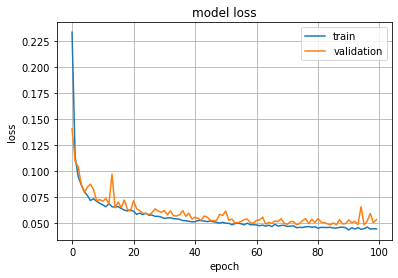

In [8]:
history = rnd_search_cv.best_estimator_.model.history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid(True)
plt.show()

**Accuracy & Evaluation**

Train Set Performance

,predicted,actual
2390,20749.0,18990
7219,13634.0,12995
873,20835.0,21888
3920,31752.0,27990
4539,11816.0,14700
...,...,...
4305,29701.0,31000
1023,41065.0,32996
1572,42443.0,43490
10245,16071.0,17000


Text(0.5, 0, 'index in train set')

Text(0, 0.5, 'price')

Text(0.5, 1.0, 'Predicted vs Actual in Train set')

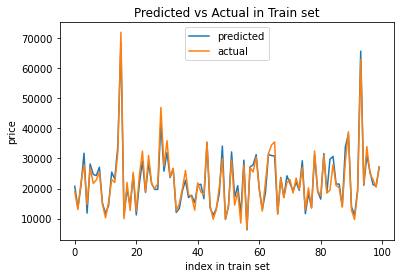

In [9]:
Y_train_pred_scaled = rnd_search_cv.predict(X_train_scaled)
Y_train_pred = scalerY.inverse_transform(Y_train_pred_scaled)

results = X_train.copy()
results["predicted"] = Y_train_pred
results["actual"] = Y_train
results = results[['predicted', 'actual']]
results['predicted'] = results['predicted'].round(0)
results

# reset the index of DataFrame and use the default indexing (0 1 2 3...N-1)
results = pd.DataFrame.reset_index(results, drop=True)

# visualize predicted vs actual in train set
plt.plot(results['predicted'].head(100), label='predicted')
plt.plot(results['actual'].head(100), label='actual')
plt.xlabel('index in train set')
plt.ylabel('price')
plt.title('Predicted vs Actual in Train set')
plt.legend()
plt.show()

Test Set Performance

,predicted,actual
10442,9108.0,9990
2907,21143.0,22382
7388,32035.0,28990
3016,24570.0,30777
7890,15027.0,14950
...,...,...
8606,31362.0,31450
8977,14847.0,12900
3673,16538.0,16750
1034,21271.0,21996


Text(0.5, 0, 'index in test set')

Text(0, 0.5, 'price')

Text(0.5, 1.0, 'Predicted vs Actual in test set')

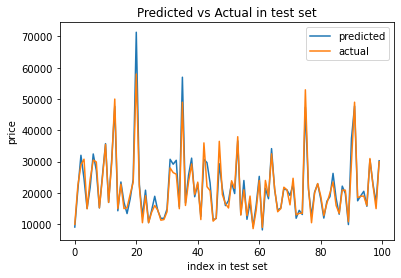

In [10]:
Y_test_pred_scaled = rnd_search_cv.predict(X_test_scaled)
Y_test_pred = scalerY.inverse_transform(Y_test_pred_scaled)

# copy the DataFrame indexes
test_results = X_test.copy()
test_results["predicted"] = Y_test_pred
test_results["actual"] = Y_test
test_results = test_results[['predicted', 'actual']]
test_results['predicted'] = test_results['predicted'].round(0)
test_results

# reset the index of DataFrame and use the default indexing (0 1 2 3...N-1)
test_results = pd.DataFrame.reset_index(test_results, drop=True)

# visualize predicted vs actual in test set
plt.plot(test_results['predicted'].head(100), label='predicted')
plt.plot(test_results['actual'].head(100), label='actual')
plt.xlabel('index in test set')
plt.ylabel('price')
plt.title('Predicted vs Actual in test set')
plt.legend()
plt.show()


Define a DataFrame object to store evaluation performance

In [11]:
model_performance = pd.DataFrame(columns=['Model', 'Train MAE', 'Train RMSE', 
                      'Test MAE', 'Test RMSE'])

Train Set Error

In [12]:
Train_MAE = mean_absolute_error(Y_train, Y_train_pred).round(0)
Train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_train_pred)).round(0)

Test Set Error

In [13]:
Test_MAE = mean_absolute_error(Y_test, Y_test_pred).round(0)
Test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_test_pred)).round(0)

Model Performance Summary

In [14]:
model_performance = model_performance.append({'Model': rnd_search_cv.best_params_,
                        'Train MAE': Train_MAE, 
                        'Train RMSE': Train_RMSE,
                        'Test MAE': Test_MAE, 
                        'Test RMSE': Test_RMSE},
                        ignore_index=True)
model_performance

,Model,Train MAE,Train RMSE,Test MAE,Test RMSE
0,"{'init': 'glorot_normal', 'learning_rate': 0.0...",1619.0,2365.0,1783.0,2648.0
